In [2]:
import requests
import tarfile
import os

url = "https://downloads.wortschatz-leipzig.de/corpora/deu_mixed-typical_2011_10K.tar.gz"
filename = "deu_mixed-typical_2011_10K.tar.gz"
extracted_dir = "deu_mixed-typical_2011_10K"
text_file_name = "deu_mixed-typical_2011_10K-sentences.txt"

# 1. Datei herunterladen
print(f"Lade Datei von {url} herunter...")
response = requests.get(url, stream=True)
if response.status_code == 200:
  with open(filename, 'wb') as f:
    f.write(response.raw.read())
  print("Download abgeschlossen.")
else:
  print(f"Fehler beim Herunterladen: Statuscode {response.status_code}")

# 2. Datei entpacken
print(f"Entpacke Datei {filename}...")
if os.path.exists(filename):
  with tarfile.open(filename, "r:gz") as tar:
    tar.extractall(".")
  print("Entpacken abgeschlossen.")
else:
  print(f"Fehler: Datei {filename} nicht gefunden.")

# 3. Text extrahieren
print(f"Extrahiere Text aus {text_file_name}...")
full_text = ""
file_path = os.path.join(extracted_dir, text_file_name)

if os.path.exists(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
      # Zeilenaufbau: Zeilennummer + Tab + Text
      parts = line.strip().split('\t', 1)
      if len(parts) > 1:
        full_text += parts[1] + " " # Füge den Text und ein Leerzeichen hinzu
  print("Textextraktion abgeschlossen.")
else:
  print(f"Fehler: Textdatei {file_path} nicht gefunden. Bitte prüfen Sie den Dateinamen im Tar-Archiv.")

Lade Datei von https://downloads.wortschatz-leipzig.de/corpora/deu_mixed-typical_2011_10K.tar.gz herunter...
Download abgeschlossen.
Entpacke Datei deu_mixed-typical_2011_10K.tar.gz...
Entpacken abgeschlossen.
Extrahiere Text aus deu_mixed-typical_2011_10K-sentences.txt...


/tmp/ipython-input-1545065770.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(".")


Textextraktion abgeschlossen.


In [3]:
import string
from collections import Counter

UNKNOWN_TOKEN = "<unk>"

def generate_word_alphabet_and_translation(corpus_text, max_vocab_size=1024, min_count=4):
  """
  Generiert ein wortbasiertes Alphabet und eine Übersetzungstabelle
  basierend auf einem gegebenen Textkorpus, optional begrenzt durch eine maximale Vokabulargröße.

  Args:
    corpus_text (str): Der Textkorpus.
    max_vocab_size (int, optional): Die maximale Größe des Vokabulars.
                                    Wenn None, wird kein Limit angewendet.

  Returns:
    tuple: Ein Tupel, das Folgendes enthält:
      - set: Das Alphabet (ein Set eindeutiger Wörter).
      - dict: Die Übersetzungstabelle (Wort zu Index).
  """
  # Einfache Worttokenisierung (kann durch komplexere Tokenizer ersetzt werden)
  words = corpus_text.lower().split()

  # Zähle die Häufigkeit der Wörter
  word_counts = Counter(words)
  # Wähle die am häufigsten vorkommenden Wörter aus
  most_common_words = [word for word, count in word_counts.most_common(max_vocab_size-1) if count >= min_count]
  alphabet = set(most_common_words)

  word_to_index = {word: i for i, word in enumerate(sorted(list(alphabet)))}
  word_to_index[UNKNOWN_TOKEN] = len(word_to_index)
  return words, alphabet, word_to_index

# Beispielaufruf mit einer maximalen Vokabulargröße von 1000
words, alphabet, word_to_index = generate_word_alphabet_and_translation(full_text, max_vocab_size=2048, min_count=4)

print(f"Größe des Vokabulars: {len(word_to_index)}")
print(list(alphabet)[:10])

Größe des Vokabulars: 1879
['zurück.', 'bilder', 'machte', 'politischen', 'du', 'noch.', 'land.', 'gelang', 'herzlich', 'bereit.']


In [4]:
import numpy as np
import tensorflow as tf
import random

WINDOW_SIZE = 8

def create_bow_dataset(words, word_to_index, window_size):
  """
  Erstellt ein Dataset für das Training von Word2Vec mit Bag-of-Words-Kontexten.

  Args:
    words (str[]): Der gesamte Textkorpus als String-Array.
    word_to_index (dict): Die Abbildung von Wörtern zu Indizes.
    window_size (int): Die Größe des Kontextfensters auf jeder Seite des Zielworts.

  Returns:
  tf.data.Dataset: Ein TensorFlow Dataset mit Paaren von (Kontext-One-Hot-Vektor, Ziel-One-Hot-Vektor).
  """
  vocab_size = len(word_to_index)

  def generator():
    word_indices = np.array([word_to_index.get(word, -1) for word in words])

    # Erstellen der Collection von Index und Token zum randomisierten Durchlaufen,
    # Reihenfolge der Wörter im Fenster darf NICHT verändert werden!
    word_collection = list(enumerate(word_indices))
    random.shuffle(word_collection)
    for i, target_index in word_collection:
      if target_index == -1:
        target_index = word_to_index[UNKNOWN_TOKEN]

      # Auswählen des fensters
      start = max(0, i - window_size)
      end = min(len(words), i + window_size + 1)
      context_indices = word_indices[start:end]

      # Entfernen des Target-Words
      context_indices = context_indices[context_indices != target_index]

      # Unbekannte wörter sollen nicht im Context sein.
      context_indices = context_indices[context_indices != -1]

      # Erstellen des BOW mit numpy
      context_vector = np.zeros(vocab_size, dtype=np.float32)
      np.add.at(context_vector, context_indices, 1)

      # Estellen des one-hot encodierten vektors.
      target_vector = np.zeros(vocab_size, dtype=np.float32)
      target_vector[target_index] = 1.0

      yield context_vector, target_vector

  dataset_size = sum(1 for _ in generator())
  print(f"Größe des Datasets: {dataset_size}")

  output_signature = (
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32),
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
  )

  dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature,
  )

  return dataset, dataset_size

# Erstelle das Dataset und erhalte die Größe
training_dataset, dataset_size = create_bow_dataset(words, word_to_index, WINDOW_SIZE)

# Cache and batch the datasets
BATCH_SIZE = 32
train_dataset = training_dataset.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

Größe des Datasets: 66004


In [5]:
class CBOWModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(CBOWModel, self).__init__()
    self.embedding = tf.keras.layers.Dense(units=embedding_dim, use_bias=False, name="word_embeddings")
    self.lookup = tf.keras.layers.Dense(units=vocab_size, activation='softmax', name="lookup")

  def call(self, inputs):
    # Inputs is the Bag-of-Words vector
    weighted_embeddings_sum = self.embedding(inputs)

    # Bilden des durchschnittlichen Contextvektors
    num_context_words = tf.reduce_sum(inputs, axis=-1, keepdims=True)
    num_context_words = tf.maximum(num_context_words, 1)

    # Berechnen des durchschnittlichen Embeddings
    average_embedding = weighted_embeddings_sum / num_context_words

    output = self.lookup(average_embedding)
    return output

EMBEDDING_DIM = 128 # Beispielwert für die Größe der Einbettung

# Definition des Modells unter Verwendung der benutzerdefinierten Klasse
model = CBOWModel(len(word_to_index), EMBEDDING_DIM)

# Modell kompilieren
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Klassifikation, richtiges Wort.
              metrics=['accuracy'])

# Trainiere das Modell einmal kurz, um die Summary zu ermöglichen
for x, y in train_dataset.take(1):
  model(x)
  break # Nur einmal aufrufen, um die Gewichte zu initialisieren

model.summary()

Model: "cbow_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embeddings (Dense)         │ (32, 128)              │       240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lookup (Dense)                  │ (32, 1879)             │       242,391 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,903 (1.84 MB)

 Trainable params: 482,903 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training des Modells
EPOCHS = 3  # Sie können die Anzahl der Epochen anpassen

# Berechnen wie viel Schritte pro epoche notwendig sind.
train_steps_per_epoch = dataset_size // BATCH_SIZE

if dataset_size % BATCH_SIZE != 0:
    train_steps_per_epoch += 1

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,
)

Epoch 1/3
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.3383 - loss: 5.2374
Epoch 2/3
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.3475 - loss: 4.4352
Epoch 3/3
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.3628 - loss: 4.3246


In [7]:
import numpy as np

# Die Gewichte der ersten Dense-Schicht (die Embedding-Schicht) extrahieren
embedding_matrix = np.transpose(model.layers[1].get_weights()[0])

# Umkehrung der Übersetzungstabelle (Index zu Wort)
index_to_word = {i: word for word, i in word_to_index.items()}

def get_word_vector(word, word_to_index, embedding_matrix):
  """
  Gibt den Vektor eines Wortes basierend auf der Einbettungsmatrix zurück.

  Args:
    word (str): Das Wort, dessen Vektor abgerufen werden soll.
    word_to_index (dict): Die Abbildung von Wörtern zu Indizes.
    embedding_matrix (np.array): Die Matrix, die die Einbettungen enthält.

  Returns:
    np.array: Der Vektor des Wortes oder None, wenn das Wort nicht im Vokabular ist.
  """
  word = word.lower()
  if word in word_to_index:
    index = word_to_index[word]
    return embedding_matrix[index]
  else:
    print(f"Warnung: Wort '{word}' nicht im Vokabular gefunden.")
    return None

def find_closest_word(vector, embedding_matrix, index_to_word, top_n=1):
  """
  Findet das Wort, dessen Vektor dem gegebenen Vektor am nächsten ist.

  Args:
    vector (np.array): Der Vektor, für den das nächste Wort gesucht wird.
    embedding_matrix (np.array): Die Matrix, die die Einbettungen enthält.
    index_to_word (dict): Die Abbildung von Indizes zu Wörtern.
    top_n (int): Die Anzahl der nächstgelegenen Wörter, die zurückgegeben werden sollen.

  Returns:
    list: Eine Liste von Tupeln (Wort, Ähnlichkeit), sortiert nach Ähnlichkeit absteigend.
  """
  # Cosinus-Ähnlichkeit berechnen
  # Normalisierung der Vektoren für die Cosinus-Ähnlichkeit
  vector_norm = np.linalg.norm(vector)
  embedding_matrix_norm = np.linalg.norm(embedding_matrix, axis=1)

  # Vermeide Division durch Null bei Null-Vektoren
  similarities = np.dot(embedding_matrix, vector) / (embedding_matrix_norm * vector_norm + 1e-8)

  # Indizes der ähnlichsten Vektoren finden
  closest_indices = np.argsort(similarities)[::-1] # Sortierung absteigend

  # Ergebnisse formatieren
  closest_words = []
  for i in range(min(top_n, len(closest_indices))):
      index = closest_indices[i]
      word = index_to_word.get(index, "Unbekanntes Wort")
      similarity = similarities[index]
      closest_words.append((word, similarity))

  return closest_words

In [10]:
# Interaktion mit dem Benutzer
while True:
    word1_input = input("Geben Sie das erste Wort ein (oder 'quit' zum Beenden): ").strip()
    if word1_input.lower() == 'quit':
        break

    vector1 = get_word_vector(word1_input, word_to_index, embedding_matrix)

    if vector1 is None:
        continue # Überspringe, wenn das erste Wort nicht im Vokabular ist

    operator = input("Geben Sie den Operator ein ('+' oder '-'): ").strip()
    if operator not in ['+', '-']:
        print("Ungültiger Operator. Bitte '+' oder '-' eingeben.")
        continue

    word2_input = input("Geben Sie das zweite Wort ein: ").strip()
    vector2 = get_word_vector(word2_input, word_to_index, embedding_matrix)

    if vector2 is None:
        continue # Überspringe, wenn das zweite Wort nicht im Vokabular ist

    # Vektorarithmetik durchführen
    if operator == '+':
        result_vector = vector1 + vector2
    elif operator == '-':
        result_vector = vector1 - vector2
    else:
        # Sollte hier nicht erreicht werden, aber zur Sicherheit
        print("Ein unerwarteter Fehler ist aufgetreten.")
        continue

    # Das ähnlichste Wort zum Ergebnisvektor finden
    closest_results = find_closest_word(result_vector, embedding_matrix, index_to_word, top_n=5) # Zeige Top 5

    print(f"\nErgebnis der Vektoroperation '{word1_input} {operator} {word2_input}':")
    for word, similarity in closest_results:
        print(f"  Nächstes Wort: '{word}' (Ähnlichkeit: {similarity:.4f})")
    print("-" * 20)

print("Programm beendet.")

Geben Sie das erste Wort ein (oder 'quit' zum Beenden): Mann
Geben Sie den Operator ein ('+' oder '-'): +
Geben Sie das zweite Wort ein: Frau

Ergebnis der Vektoroperation 'Mann + Frau':
  Nächstes Wort: 'aufbau' (Ähnlichkeit: 0.9792)
  Nächstes Wort: 'turm' (Ähnlichkeit: 0.9779)
  Nächstes Wort: 'bürgermeister' (Ähnlichkeit: 0.9777)
  Nächstes Wort: 'ob' (Ähnlichkeit: 0.9773)
  Nächstes Wort: 'nacht' (Ähnlichkeit: 0.9771)
--------------------
Geben Sie das erste Wort ein (oder 'quit' zum Beenden): quit
Programm beendet.


In [11]:
!pip install gensim

In [12]:
EMBEDDING_DIM = 32 # Beispielwert für die Größe der Einbettung
WINDOW_SIZE = 16

# Tokenisiere den vollen Text in eine Liste von Sätzen, wobei jeder Satz eine Liste von Wörtern ist.
# Eine einfache Tokenisierung, die den Text nach Satzzeichen aufteilt.
import re
sentences = re.split(r'[.!?]+', full_text.lower())
# Tokenisiere jeden Satz in Wörter
tokenized_sentences = [sentence.split() for sentence in sentences if sentence.strip()]

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

# Trainiere das Word2Vec Modell
# vector_size ist die Dimension der Einbettung
# window ist die Größe des Kontextfensters
# min_count filtert Wörter unterhalb einer bestimmten Frequenz heraus
# sentences muss eine Liste von Listen von Wörtern sein
model = Word2Vec(sentences=tokenized_sentences,
                 vector_size=EMBEDDING_DIM,
                 window=WINDOW_SIZE,
                 min_count=1,
                 workers=4)

# Teste, ob ein Wort im Vokabular ist und gib seinen Vektor zurück
test_word = 'haus'  # Beispielwort
try:
    vector = model.wv[test_word]
    print(f"Vektor für '{test_word}':\n{vector[:10]}...") # Gebe nur die ersten 10 Elemente aus
except KeyError:
    print(f"Wort '{test_word}' nicht im Vokabular gefunden.")

# Finde ähnliche Wörter zu einem gegebenen Wort
similar_words = []
test_word_similar = 'könig' # Beispielwort für ähnliche Wörter
try:
    similar_words = model.wv.most_similar(test_word_similar)
    print(f"\nÄhnliche Wörter zu '{test_word_similar}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.4f}")
except KeyError:
    print(f"Wort '{test_word_similar}' nicht im Vokabular gefunden.")

# Beispiel für Vektorarithmetik: König - Mann + Frau
word1 = 'könig'
word2 = 'mann'
word3 = 'frau'

print(f"\nTeste Vektorarithmetik: '{word1}' - '{word2}' + '{word3}'")

try:
    result_vector = model.wv[word1] - model.wv[word2] + model.wv[word3]
    # Finde das ähnlichste Wort zum Ergebnisvektor
    closest_results_arithmetic = model.wv.most_similar(positive=[word1, word3], negative=[word2], topn=5)
    print("Ergebnis:")
    for word, similarity in closest_results_arithmetic:
        print(f"  {word}: {similarity:.4f}")

except KeyError as e:
    print(f"Fehler: Ein Wort wurde nicht im Vokabular gefunden - {e}")

Vektor für 'haus':
[-0.05643978 -0.07884913  0.10437613  0.13344565  0.01711173 -0.07650819
  0.11665313  0.03684052 -0.05220457  0.01350103]...

Ähnliche Wörter zu 'könig':
  hochzeitslexikon: 0.6824
  mediationsverfahren: 0.6784
  erwacht: 0.6724
  bollywood: 0.6539
  rohr: 0.6227
  peinlicher: 0.6166
  armen: 0.6083
  privat: 0.6013
  entnahmen: 0.5894
  quero: 0.5858

Teste Vektorarithmetik: 'könig' - 'mann' + 'frau'
Ergebnis:
  hochzeitslexikon: 0.6737
  bollywood: 0.6710
  rohr: 0.6546
  erwacht: 0.6459
  km²: 0.6414


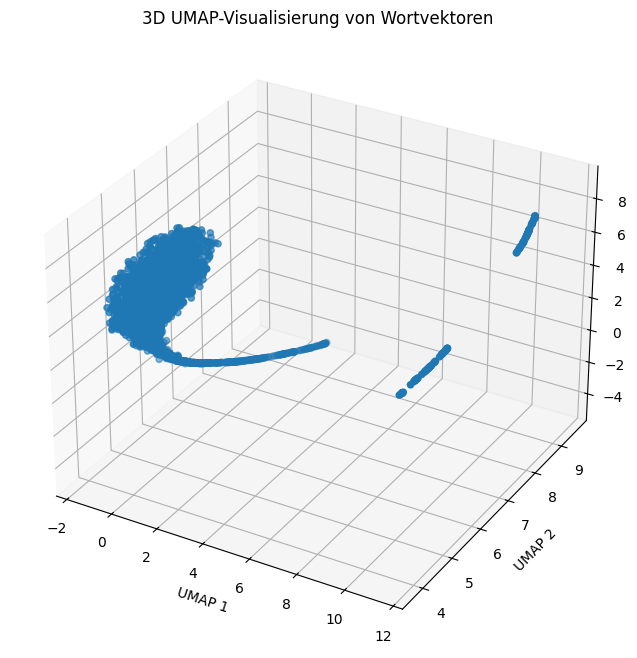

In [13]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Vektoren und die entsprechenden Wörter aus dem Word2Vec-Modell
word_vectors = model.wv.vectors
words = list(model.wv.index_to_key)

# Reduziere die Dimensionen der Vektoren mit UMAP auf 3D
reducer = umap.UMAP(n_components=3) # Auf 3 Komponenten für 3D
embedding_3d = reducer.fit_transform(word_vectors)

# Erstelle einen Pandas DataFrame für einfachere Handhabung
df_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_3d['word'] = words

# Wähle einige der wichtigsten Wortgruppen aus (basierend auf Häufigkeit oder Relevanz)
# Hier wählen wir einfach die ersten 100 Wörter im Vokabular als Beispiel
num_words_to_plot = 4096
df_plot = df_3d.head(num_words_to_plot)

# Plotten der 3D-Einbettungen
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Punkt für jedes Wort
ax.scatter(df_plot['UMAP1'], df_plot['UMAP2'], df_plot['UMAP3'])

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D UMAP-Visualisierung von Wortvektoren')

plt.show()
